Note: **I am currently seeking employment as a Data {Scientist/Engineer}** in the Greater Seattle Area! 
* [jai@jaibot.com](mailto:jai@jaibot.com)
* [Résumé](https://github.com/jaibot/resume/raw/master/resume.pdf)
* [LinkedIn](https://www.linkedin.com/in/jaidhyani)
* [GitHub](https://github.com/jaibot/)
* [Website](http://www.jaibot.com/)

# Intrade: Analyzing Market Accuracy and Exploitable Miscalibrations in the Prediction Market

Prediction markets are an instrument to convert profit motive into accurate predictions about the future. Like a stock market, prediction markets consist of shares that are bought and sold by traders in a free market. Unlike a stock market, the shares do not represent partial ownership of companies, goods, or other financial instruments, but rather ownership of a bet about a future event. When the event has come to pass, the share is worth its full face value (e.g. \$1.00). However, if the event does not come to pass, the share is worth \$0.00. The expected behavior, then, is for market prices to reflect probabilities. 

For example, consider a contract that says "AlphaGo will win three or more matches against Lee Sedol", which pays out \$1.00. If I think that this has a 30% chance of coming true, then I value shares of this contract at \$0.30 in expectation. If I can buy shares for less than that price, than I will want to buy them. Conversely, if shares are trading for more than \$0.30, I will want to short them - that is, I will take the other side of the bet. In this way, we expect the market to harness the collective intelligence of traders to make accurate predictions about the future.

If this works as expected, then we have a well-calibrated instrument for predicting the future. If it doesn't, then we can exploit the weaknesses we find to systemically profit off of the miscalibrated market.

For this project, I analyzed every recorded trade ever executed on the Intrade Prediction Market over ten years - over two million trades in over ten thousand contracts. I looked for patterns and systemic signs of miscalibration or other divergences from a theoretically well-calibrated prediction market.

Here I present two major interesting results (so far): **Intrade had a strong preference for round-number probabilities**, and **Intrade was systemically underconfident about political outcomes**.

The full source of the code I used to generate these results is available at https://github.com/jaibot/IntradeAnalysis/blob/master/intrade.ipynb, and is still a work in progress as of this writing. The data I used is available at https://github.com/jaibot/IntradeData. The pickled data I load here is too large to be stored on github, but may be found at http://www.jaibot.com/tradedays.pickle (all-time daily-sampled data) and http://www.jaibot.com/final60.pickle (hourly-sampled data from the last 60 days of contracts).

In [2]:
# Importing data, libraries
DATA_DIR = '/home/jai/IntradeData/intrade/'

import pickle
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
td = pd.datetools.timedelta

In [ ]:
with open(os.path.join(DATA_DIR, 'trades.pickle')) as f:
    trades = pickle.load(f)
    
with open(os.path.join(DATA_DIR, 'daily_prices.pickle')) as f:
    daily_prices = pickle.load(f)
    
with open(os.path.join(DATA_DIR, 'countdown_prices.pickle')) as f:
    countdown_prices = pickle.load(f)
    
with open(os.path.join(DATA_DIR, 'roidata.pickle')) as f:
    roidata = pickle.load(f)

with open(os.path.join(DATA_DIR, 'market_correlation.pickle')) as f:
    market_corr = pickle.load(f)

In [5]:
final60 = countdown_prices[
    (countdown_prices.duration > td(days=60)) & 
    (countdown_prices.countdown > -td(days=60))]

## Example Markets: 2008 GOP Presidential Nomination

Here, we look at the prices of contracts for different individuals to become the 2008 GOP Presidential nominee, reflecting the probabilities that the market placed on those individuals at the time.

Some notes on this data:
* We sample prices on a daily basis.
* We take the last price at which a trade was executed on any given day.
* For days on which a contract was not traded, we take the most recent trading price. This reflects an assumption that a lack of trading implies that the market believes that the current price is well-calibrated.
* For simplicity, we're looking only at the top five candidates, according to the peak price (probability) they ever achieved.
* Note that market believes that the outcome is near-certain for some time before the market officially closes. This is a common pattern in prediction markets of this type.

<IPython.core.display.Javascript object>


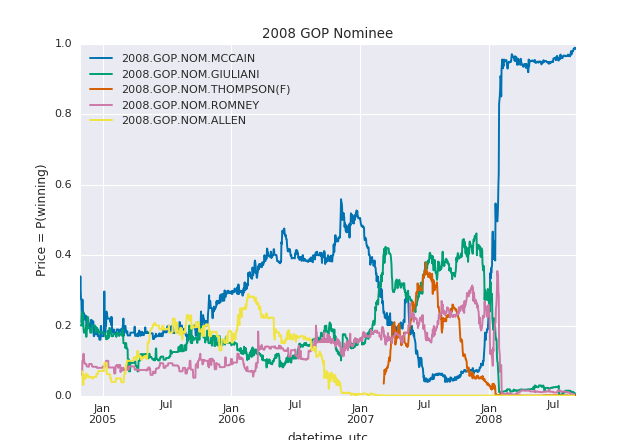

In [6]:
# select data
gop_nom = daily_prices[daily_prices.market_symbol.str.startswith('2008.GOP.NOM')]
peaks = gop_nom.groupby('market_symbol').p.max()
top_cands = peaks.sort_values(ascending=False).index[:5]

# plot
%matplotlib notebook

colors = sns.color_palette('colorblind', n_colors=5)
ax = plt.gca()
for cand in top_cands:
    vals = gop_nom[gop_nom.market_symbol==cand].p
    vals.plot(ax=ax, label=cand, color=colors.pop(0))
ax.set_title('2008 GOP Nominee')
ax.legend(loc='upper left');
ax.set_ylabel('Price = P(winning)');

# Log Loss


When scoring predictions, we want to reward highly confident correct predictions and discourage highly-confident incorrect predictions. The [log loss scoring rule](https://en.wikipedia.org/wiki/Scoring_rule#Logarithmic_scoring_rule) achieves this, as well as having a number of other desirable mathematical properties. Here, we rate Intrade's predictions under log loss, and example how different subsets of markets perform to get a better idea of Intrade's strengths and weaknesses.

## Log Loss - Final 60 Days

Here we look at log loss over all contracts in the sixty days before they close.

<IPython.core.display.Javascript object>


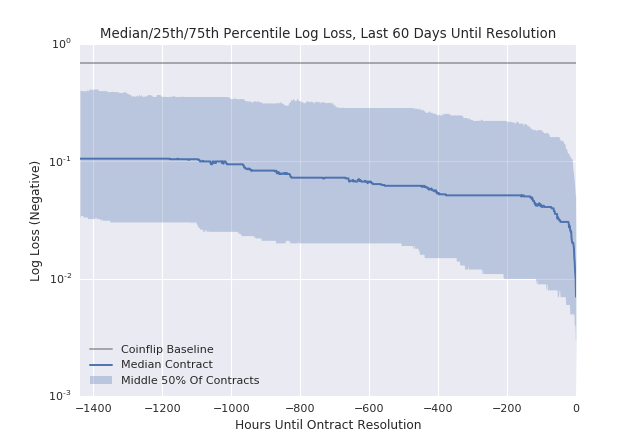

In [7]:
%matplotlib notebook

bycd = final60.groupby('countdown')
ll = bycd.logloss.median()
hours = ll.index.total_seconds()/3600
ll50 = -ll.values
ll25 = -bycd.logloss.quantile(0.25)
ll75 = -bycd.logloss.quantile(0.75)

ax = plt.gca()
ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='Coinflip Baseline')
ax.plot(hours, ll50, label='Median Contract')
ax.fill_between(hours, ll25, ll75, alpha=0.3, linewidth=0.0, label='Middle 50% Of Contracts')
ax.set_yscale('log');
ax.set_xlim(hours.min(), hours.max())
ax.set_title('Median/25th/75th Percentile Log Loss, Last 60 Days Until Resolution')
ax.set_xlabel('Hours Until Ontract Resolution')
ax.set_ylabel('Log Loss (Negative)');
ax.legend(loc='lower left');


* Here, the solid line depicts the *median* contract (when ranked by log-loss at any given time).
* Note: Here the data is sampled on an hourly basis. This it to get more fine-grained detail in the hours leading up to the contract's resolution.
* The data set did not label contract resolutions - in other words, it didn't say whether contracts were declared to have happened or not happened. Instead, I've classified contracts based on their final trading price. If above 95%, I classify the contract as having come true. If the final trade is below 5%, I classify the contract as haing not come true. Random sampling of contracts, as well as specifically examining "surprising" contracts (where markets went from near-certain to very-unlikely or vice versa), and comparing those results against manually-verified real-world outcomes, found no cases where this methodology produced an incorrect result - though it's always possible I missed something. The few contracts whose final trades were not above 95% or below 5% are excluded from this analysis.
* The data set also does not list contract closing times; we use the time of the final trade as an approximation. This may misrepresent the data in the case of low-volume markets if there was a significant time-lag between the final trade and market closure. TODO: Examine distribution of time betwen final trades in contracts. to see if this could be a confounding factor.
* We are looking at negative log loss - meaning that y=0 represents a perfect oracle. We draw a line at -log(0.5), representing the log loss of a predictor who assigns 50% confidence to all outcomes. We call this the "coinflip baseline".
* The line represents median contract performance; the shaded area, all contracts between the 25th and 75 percentile (when ranked by log loss).
* $10^-3$ is the best possible score - since Intrade's contracts were trades at between \$0.01 and \$9.99, the maximal and minimal probabilities expressable by the market were 0.999 and 0.001, respectively.
* We see that Intrade significantly outperforms a coinflip baseline, even at the 25th percentile of its contracts.
* We also observe that Intrade's predictions gradually improved in the two months leading up to resolution, though not dramatically so.
* We do see dramatic improvement in the final hours/days of the contracts - this seems to reflect a common situation where there's a slight delay between the outcome becoming widely known and the contract being officially resolved.

## Log Loss - Final 60 Days (By Year)

Here, we look at the time timeframe - all contracts over the last 60 days (1440 hours) before their resolution, but broken out by year (of contract resolution).

In [8]:
# collect information
yearlyll = {}
for y in xrange(2004, 2013):
    ll = dict()
    data = final60[final60.final_year==y]
    hb = data.groupby('countdown')
    ll['hours'] = hb.countdown.first()/3600000000000
    ll['25'] = -hb.logloss.quantile(0.25)
    ll['50'] = -hb.logloss.median()
    ll['75'] = -hb.logloss.quantile(0.75)
    yearlyll[y] = ll

<IPython.core.display.Javascript object>


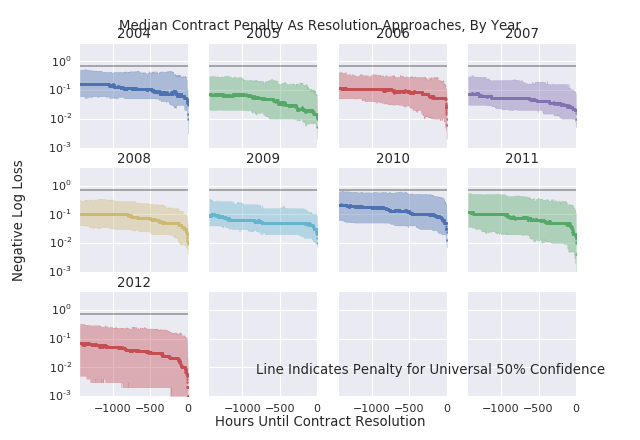

In [9]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(3, 4, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, y in zip(axes, yearlyll.iteritems()):
    color = palette.pop(0)
    year, ll = y
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=year, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(int(year))
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Year', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical')
fig.text(0.4, 0.15, 'Line Indicates Penalty for Universal 50% Confidence');

* We observe that Intrade's overall predictive patterns were pretty similar across its lifetime, always gradually improving as resolution nears. Intrade also consistently and comfortably beat the conflip baseline in all years.
* If you look closely, you'll notice that rapid late improvements seem to be more common in election years - possibly suggesting that they're largely driven by election-night returns outpacing Intrade officially resolving the contracts.
* 2012, the last full year in which Intrade was operating, and the last Presidential year, was an unusually strong year for Predictions, possibly suggesting that Intrade as a whole was becoming better calibrated over time.

## Log Loss - Final 60 Days (By Category)

In [10]:
catll = {}
cats = ('Politics', 'Entertainment', 'Current Events', 'Legal', 'Foreign Affairs')
for c in cats:
    ll = dict()
    data = final60[final60.category==c]
    hb = data.groupby('countdown')
    ll['hours'] = hb.countdown.first()/3600000000000
    ll['25'] = -hb.logloss.quantile(0.25)
    ll['50'] = -hb.logloss.median()
    ll['75'] = -hb.logloss.quantile(0.75)
    catll[c] = ll

<IPython.core.display.Javascript object>


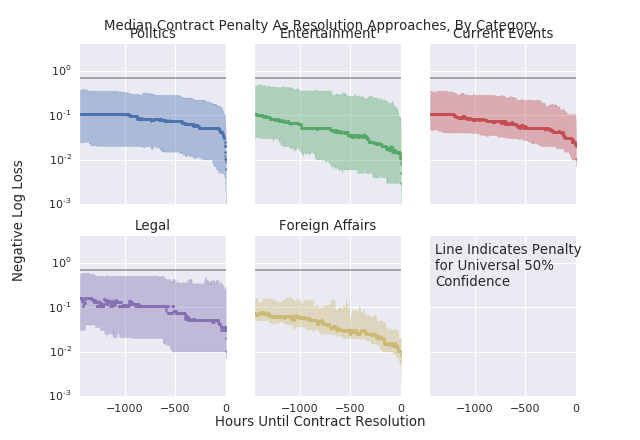

In [11]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(2, 3, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, cat in zip(axes, cats):
    color = palette.pop(0)
    ll = catll[cat]
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=cat, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(cat)
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Category', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical');
fig.text(0.68, 0.35, 'Line Indicates Penalty\nfor Universal 50% \nConfidence');

Here, we observe that all of Intrade's top five categories demostrate similar performance as resolution approaches. This suggests that prediction markets' abilities generalize well to different areas.

## Log Loss - Intrade All-Time Performance

In [14]:
daygrp = daily_prices.groupby('date')
volume = daygrp.volume.sum()
log_loss = -daygrp.logloss.median()
vlowlog_loss = -daygrp.logloss.quantile(0.05)
lowlog_loss = -daygrp.logloss.quantile(0.25)
highlog_loss = -daygrp.logloss.quantile(0.75)
vhighlog_loss = -daygrp.logloss.quantile(0.95)

<IPython.core.display.Javascript object>


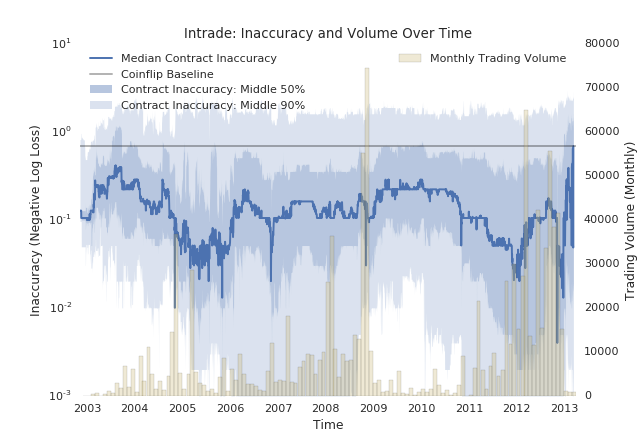

In [15]:
%matplotlib notebook
mvolume = volume.asfreq('M')
sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

colors = sns.color_palette()
colora = colors[0]
colorb = colors[4]

ax = plt.gca()
ax2 = ax.twinx()
ax.grid(False)
ax2.grid(False)
dates=log_loss.index
ax.set_yscale('log')

ax2.bar(mvolume.index, mvolume.values, color=colorb, width=30, alpha=0.3, label='Monthly Trading Volume')
ax.plot(log_loss.index, log_loss.values, '-', label='Median Contract Inaccuracy', color=colora)
ax.fill_between(dates, lowlog_loss, highlog_loss, 
                alpha=.4, color=colora, 
                label='Contract Inaccuracy: Middle 50%', linewidth=0.0)
ax.fill_between(dates, vlowlog_loss, lowlog_loss, 
                alpha=.2, color=colora, 
                label='Contract Inaccuracy: Middle 90%', linewidth=0.0)
ax.fill_between(dates, highlog_loss, vhighlog_loss, alpha=.2, color=colora, linewidth=0.0)



ax.set_xlabel('Time')
ax.set_ylabel('Inaccuracy (Negative Log Loss)')
ax2.set_ylabel('Trading Volume (Monthly)')
ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='Coinflip Baseline')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_title("Intrade: Inaccuracy and Volume Over Time");

Here, we look at the performance of all Intrade contracts over all time.
* Again, the line represents median contract performance on any given day.
* We overlay bars to illustrate the volume of activity on the market at any given time.
* We see spikes in activity coincident with rapid (though momentary) improvements in overall market performance. Looking at the dates, these correspond exactly with primary and general elections.
* Here, we've shaded not just the middle 50% of contracts, but the middle 90% as well.

# Schelling Prices (or: God Does Not Play Twenty-Sided Dice)

<IPython.core.display.Javascript object>


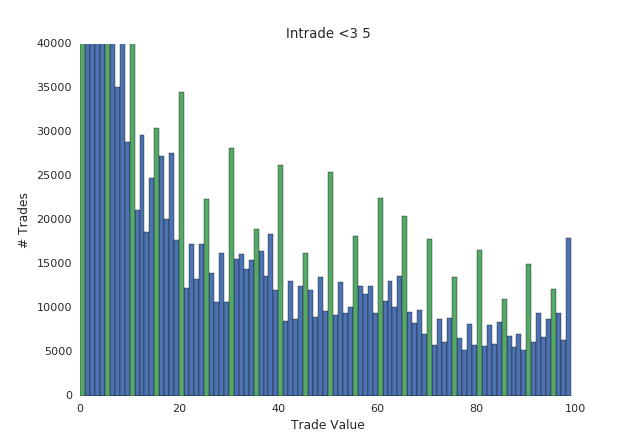

In [16]:
%matplotlib notebook
ax = plt.gca()
roundt = (100*trades.p).round(0)
roundt[roundt%5!=0].hist(bins=np.arange(100), ax=ax)
roundt[roundt%5==0].hist(bins=np.arange(100), ax=ax)
ax.set_ylim(0, 40000)
ax.set_title('Intrade <3 5')
ax.set_xlabel('Trade Value')
ax.set_ylabel('# Trades');

This is a histogram depciting how often trades occured at varying price levels. We see that trades at prices divisible by 5 were far more common that trades at other prices, suggesting that the market believes that events are genreally more likely to have probabilities numerically divible by 5. REALITY DOES NOT WORK THIS WAY. There are not twenty probabilities privileged above all others; God does not play twenty-sided dice. (We can also see similar biases towards probabilities divisible by 10 and 2.)

Research into predictors suggests that fine-grained predictions are a necessary component of highly-accurate forecasts. From Superforecasting:
> Barbara Mellers has shown that granularity predicts accuracy: the average forecaster who sticks with the tens – 20%, 30%, 40% – is less accurate than the finer-grained forecaster who uses fives – 20%, 25%, 30% – and still less accurate than the even finer-grained forecaster who uses ones – 20%, 21%, 22%. As a further test, she rounded forecasts to make them less granular, so a forecast at the greatest granularity possible in the tournament, single percentage points, would be rounded to the nearest five, and then the nearest ten. This way, all of the forecasts were made one level less granular. She then recalculated Bier scores and discovered that superforecasters lost accuracy in response to even the smallest-scale rounding, to the nearest 0.05, whereas regular forecasters lost little even from rounding four times as large, to the nearest 0.2.

This suggests that Intrade's prevalence of round-numbered trading is a systemic weakness that could be systemtically exploited, especially on events where a good forecaster placed the probability at a decidedly-non-round number.

# Return on Investment

Here we examine Intrade contracts as financial instruments, specifically looking for evidence of circumstances under which contracts systemically and predictably lose or gain money relative to investment.

In a well-calibrated market, this should not happen; the market should be neutral with regard to all criteria, with  no predictable opportunities to make money. If we can find criteria that accurately predict whether a class of contract will make or lose money in advance, we have uncovered a systemic miscalibration in the market that we can exploit for profit, or use to inform our interpretation of prediction markets' probabilities.

## Systemic Underconfidence

<IPython.core.display.Javascript object>


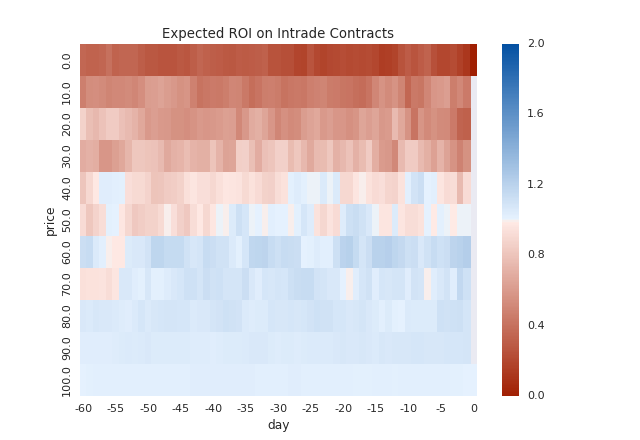

In [7]:
cmap = sns.diverging_palette(h_neg=15, h_pos=255, s=99, l=35, sep=1, n=15, as_cmap=True)


def roiheatmap(roidata, ax=None, cbar=True, cbar_ax=None):
    ax = ax or plt.gca()
    binned = roidata.groupby(['price', 'day']).roi.mean().reset_index()
    pivoted = binned.pivot(index='price', columns='day', values='roi')
    ax.set_title('Expected ROI on Intrade Contracts')
    ax.set_xlabel('Days Until Contract Resolution')
    return sns.heatmap(pivoted, 
                       cmap=cmap, 
                       center=1.0, 
                       xticklabels=5, 
                       ax=ax, 
                       cbar=cbar, 
                       cbar_ax=cbar_ax);

%matplotlib notebook
roiheatmap(roidata);

This heatmap depicts ROI for contracts by price level (y-axis: from p=0% to p=100%) and days until contract resolution (x-axis, from 60 days out to resolution day), with color denoting mean ROI for that class of contract (red for loss and blue for gain). 

The heatmap reveals systemic underconfidence in the Intrade Prediction Market, and moreover systemic underconfidence that appears to be larely invariant with respect to time.

* The red area among the low-value contracts means that buying those contracts at market prices systemically loses money. This means that those contracts happen *even less frequently* than Intrade's already-low odds would suggest.
* The blue area among high-value contracts means that buying those contracts at market prices systemically gains money, meaning that those contracts come true *even more frequently* than Intrade's high prices suggest.
* This underconfidence dos not appear to abate as contract resolution approaches.
* This implies that you could make money by purchasing contracts valued at over p=0.5, and shorting contracts valued at less than p=0.5. This implies an ongoing systemic weakness in Intrade.
* In this heatmap, we've binned contract prices by day (using sampling methods previously descrined) and by probability/price intervals of 10%.
* This analysis excludes markets that were open for less than 60 days.

### Underconfidence Stems from Political Contracts

<IPython.core.display.Javascript object>


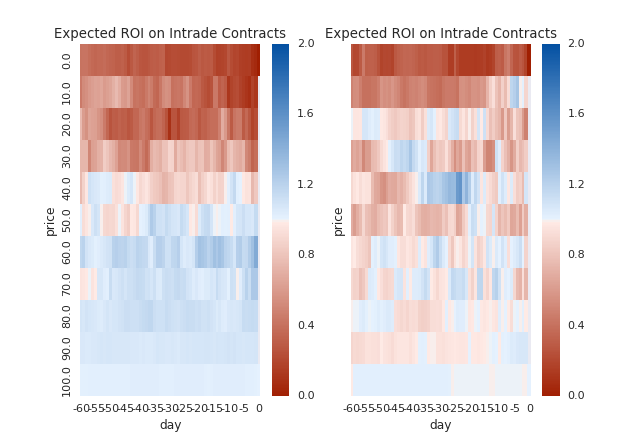

In [8]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
roiheatmap(roidata[roidata.category=='Politics'], ax1)
roiheatmap(roidata[roidata.category!='Politics'], ax2);

By comparing ROI on political contracts (left) to ROI on all other types of contracts (right), we can see that this bias towards underconfidence seems to be driven by political contracts. We do see what looks like similar underconfidence among low-probability-non-political contracts, but the pattern is less robust (and shows evidence of market correction as resolution approaches).

Even though the pattern is largely confined to politics, we see this effect show up in an overall analysis because over 60% of all markets in this analysis are in the 'Politics' category. 

At the moment, I cannot state with any confidence what is causing this effect, only that it appears pretty robust.

### Breaking out Results by Trading Volume

<IPython.core.display.Javascript object>


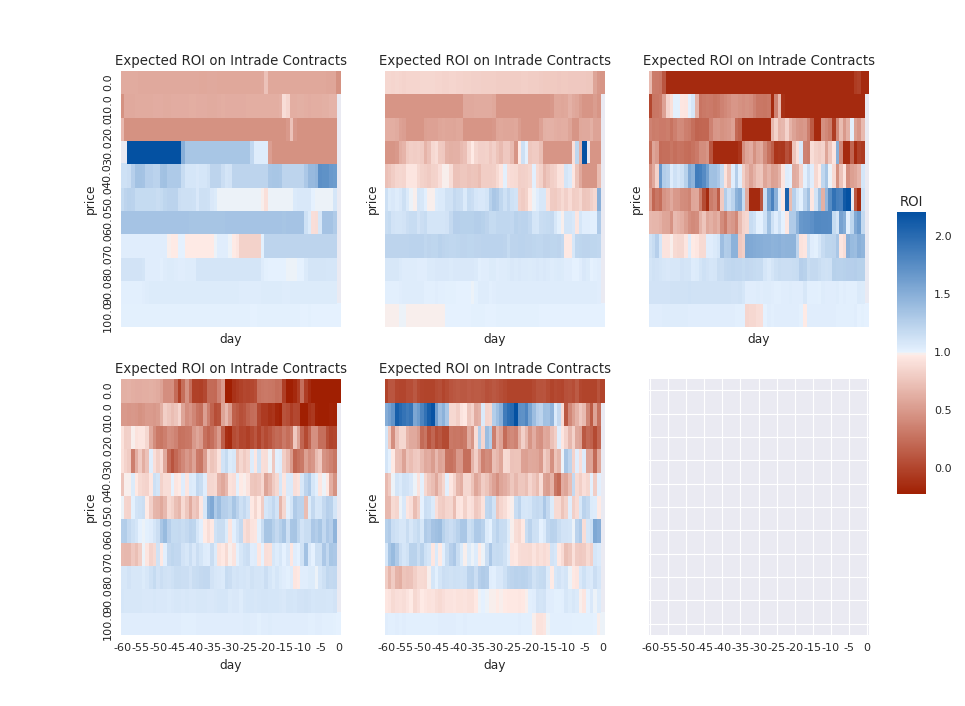

In [9]:
%matplotlib notebook
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.93, .3, .03, .4])
cbar_ax.set_title('ROI')
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume<100)], ax1, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume.between(100, 500))], ax2, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume.between(500, 1000))], ax3, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume.between(1000, 10000))], ax4, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume>10000)], ax5, cbar_ax=cbar_ax);

Here we've broken out the political contracts by total volume (e.g. the number of shares traded over the lifetime oft he contract). In the top row are contracts with fewer than 100 shares traded, between 100 and 500 shares traded, and between 500 and 1000 shares traded. In the bottom row, contracts with 10,000 to 100,000 shares traded, and finally contracts with more than 100,000 shares trades. We observe that the effect decreases as trading volume increases - though it still seems to be present even among high-volume contracts. This suggests that some, though not all, of the effect owes to a lack of liquidity in some markets.

# Market Correlation

It occured to me that what appears to be systemic underconfidence might be a result of highly-correlated markets conforming to the same result. In this case, we would not expect "surprises" to be evenly distributed, but to manifest in large groups - specifically, with political contracts, we might expect an election to have a large number of surprises or very few. To test this, and to develop models to try to exploit the market's preference for round numbers, I began to look into ways to measure cross-market correlation.

To measure market correlation, it is insufficient to directly measure price correlation. Rather, we want to measure correlation in *changes in evidence* over time - that is, when the market suggests that there is more evidence for or against one outcome, we look for signs of a similar update on evidence in the other outcome.

To do this, we convert price to log-odds ratio and look at the daily change over time. This roughly equates to looking at *new evidence for or against an outcome occuring, according to the market*. We then look for correlation among these updates across contracts.

In [22]:
obama_sen_corr = market_corr[
    market_corr.m1_name.eq('2008.PRES.OBAMA') & 
    market_corr.m2_name.str.endswith('SENATE08.DEM')].sort_values(
    'abscorrelation', ascending=False)
obama_sen_corr

,m2,m1,correlation,abscorrelation,m1_name,m2_name,m1_category,m2_category
8554002,471507.0,409933.0,0.711765,0.711765,2008.PRES.OBAMA,NC.SENATE08.DEM,Politics,Politics
8553995,471495.0,409933.0,-0.647956,0.647956,2008.PRES.OBAMA,KY.SENATE08.DEM,Politics,Politics
8553997,471500.0,409933.0,-0.491934,0.491934,2008.PRES.OBAMA,MN.SENATE08.DEM,Politics,Politics
8553992,471488.0,409933.0,0.469103,0.469103,2008.PRES.OBAMA,CO.SENATE08.DEM,Politics,Politics
8554003,471509.0,409933.0,0.300371,0.300371,2008.PRES.OBAMA,OR.SENATE08.DEM,Politics,Politics


Here we see some counterinutitive results - reflecting that fact that what we're actually seeing is correlation between election-night returns - the two negative correlations are senate races that appeared to have been won by Republicans on election night. To produce more interesting results, at least for political contracts, we should exclude this kind of evidence. This remains a work in progress.